$\newcommand{\dS}{\,\text{dS}}
\newcommand{\dx}{\,\text{dx}}
\newcommand{\bsig}{\boldsymbol{\sigma}}$

# Computing consistent reaction forces

One often needs to compute a resulting reaction force on some part of the boundary as post-processing of a mechanical resolution.

Quite often, such a reaction will be computed using the stress field associated with the computed displacement. We will see that this may lead to slight inaccuracies whereas another more consistent approach using the virtual work principle is more consistent.


## A cantilever beam problem

We reuse here a simple 2D small strain elasticity script of a rectangular domain of dimensions $L\times H$ representing a cantilever beam clamped on the left hand-side and under uniform body forces $\boldsymbol{f}=(f_x, f_y)$. $P^2$ Lagrange elements are used for the displacement discretization. 

For the sake of illustration, we are interested in computing the horizontal and vertical reaction forces $R_x$ and $R_y$ on the left boundary as well as the resulting moment $M_z$ around the out-of-plane direction. In the present simple case using global balance equations, they are all given explicitly by:
$$
\begin{align*}
R_x &= \int_{x=0} \boldsymbol{T}\cdot \boldsymbol{e}_x \dS = \int_{x=0} (-\sigma_{xx}) dS = -f_x \cdot L \cdot H \\
R_y &= \int_{x=0} \boldsymbol{T}\cdot \boldsymbol{e}_y \dS = \int_{x=0} (-\sigma_{xy}) dS = -f_y \cdot L \cdot H\\
M_z &= \int_{x=0} (\vec{\boldsymbol{OM}}\times \boldsymbol{T})\cdot \boldsymbol{e}_z \dS = \int_{x=0} (y \sigma_{xx}) dS = f_y \cdot \dfrac{L^2}{2} \cdot H
\end{align*}
$$

<IPython.core.display.Javascript object>


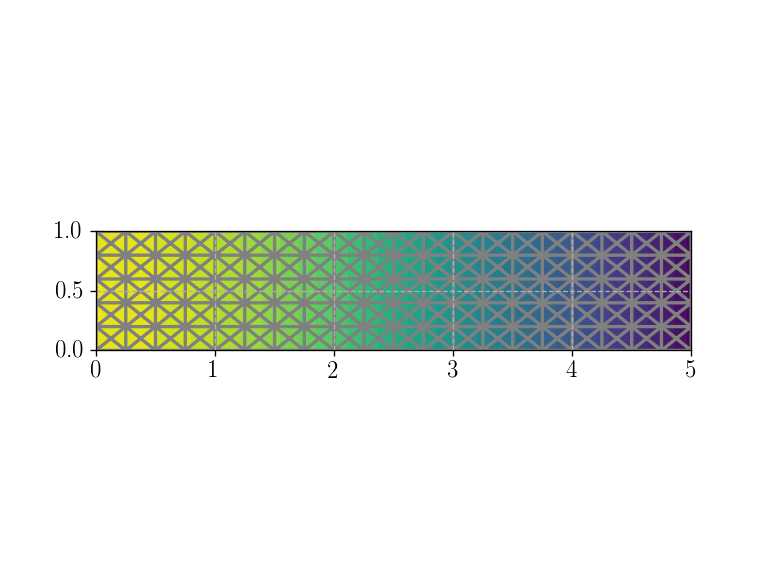

In [6]:
from dolfin import *
import matplotlib.pyplot
%matplotlib notebook

L = 5.
H = 1.
Nx = 20
Ny = 5
mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")
plot(mesh)

E = Constant(1e5)
nu = Constant(0.3)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)


def eps(v):
    return sym(grad(v))


def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)


fx = 0.1
fy = -1.
f = Constant((fx, fy))

V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*dx
l = inner(f, u_)*dx


def left(x, on_boundary):
    return near(x[0], 0.)


facets = MeshFunction("size_t", mesh, 1)
AutoSubDomain(left).mark(facets, 1)
ds = Measure("ds", subdomain_data=facets)
bc = DirichletBC(V, Constant((0., 0.)), facets, 1)

u = Function(V, name="Displacement")
solve(a == l, u, bc)
plot(u[1])

## First method: using the post-processed stress

The first, and most widely used, method for computing the above reactions relies on the stress field computed from the obtained displacement `sigma(u)` and perform `assemble` over the left boundary (measure `ds(1)`). Unfortunately, this procedure does not ensure an exact computation as seen below. Indeed, the stress field, implicitly known only at the quadrature points only is extended to the structure boundary and does not satisfy global equilibrium anymore.

In [11]:
x = SpatialCoordinate(mesh)

print("Horizontal reaction Rx = {}".format(
    assemble(-sigma(u)[0, 0]*ds(1))))
print("             (analytic = {})".format(-L*H*fx))
print("-"*50)
print("Vertical reaction Ry = {}".format(
    assemble(-sigma(u)[0, 1]*ds(1))))
print("           (analytic = {})".format(-L*H*fy))
print("-"*50)
print("Bending moment Mz = {}".format(assemble(-x[1]*sigma(u)[0, 0]*ds(1))))
print("        (analytic = {})".format(H*L**2/2*fy))
print("-"*50)
print("\n")

Horizontal reaction Rx = -0.48578099336058145
             (analytic = -0.5)
--------------------------------------------------
Vertical reaction Ry = 4.514399579992231
           (analytic = 5.0)
--------------------------------------------------
Bending moment Mz = -12.057524729246653
        (analytic = -12.5)
--------------------------------------------------




## Second method: using the work of internal forces

The second approach relies on the virtual work principle (or weak formulation) which writes in the present case:
$$
\int_\Omega \bsig(\boldsymbol{u}):\nabla^s \boldsymbol{v} \dx =\int_\Omega \boldsymbol{f}\cdot\boldsymbol{v} \dx + \int_{\partial \Omega_N} \boldsymbol{T}\cdot\boldsymbol{v}\dS + \int_{\partial \Omega_D} \boldsymbol{T}\cdot\boldsymbol{v}\dS \quad \forall \boldsymbol{v}\in V
$$

in which $\boldsymbol{v}$ does not necessarily satisfy the Dirichlet boundary conditions on $\partial \Omega_D$. 

The solution $u$ is precisely obtained by enforcing the Dirichlet boundary conditions on $\boldsymbol{v}$ such that:
$$
\int_\Omega \bsig(\boldsymbol{u}):\nabla^s \boldsymbol{v} \dx =\int_\Omega \boldsymbol{f}\cdot\boldsymbol{v} \dx + \int_{\partial \Omega_N} \boldsymbol{T}\cdot\boldsymbol{v}\dS \quad \forall \boldsymbol{v}\in V \text{ and } \boldsymbol{v}=0 \text{ on }\partial \Omega_D
$$

Defining the **residual**:
$$
Res(v) = \int_\Omega \bsig(\boldsymbol{u}):\nabla^s \boldsymbol{v} \dx - \int_\Omega \boldsymbol{f}\cdot\boldsymbol{v} \dx - \int_{\partial \Omega_N} \boldsymbol{T}\cdot\boldsymbol{v}\dS = a(\boldsymbol{u}, \boldsymbol{v}) -\ell(\boldsymbol{v}) 
$$

we have that $Res(v)= 0$ if $\boldsymbol{v}=0$ on $\partial \Omega_D$.

Now, if $\boldsymbol{v}\neq0$ on $\partial \Omega_D$, say, for instance, $\boldsymbol{v}=(1,0)$ on $\partial \Omega_D$, we have that:
$$
Res(v) = \int_{\partial \Omega_D} \boldsymbol{T}\cdot\boldsymbol{v}\dS = \int_{\partial \Omega_D} \boldsymbol{T}_x\dS = \int_{\partial \Omega_D} -\sigma_{xx}\dS = R_x
$$

Similarly, we obtain the vertical reaction $R_y$ by considering $\boldsymbol{v}=(0,1)$ and the bending moment $M_z$ by considering $\boldsymbol{v}=(y,0)$.

As regards implementation, the residual is defined using the action of the bilinear form on the displacement solution: `residual = action(a, u) - l`. We then define boundary conditions on the left boundary and apply them to an empty Function to define the required test field $v$. We observe that the computed reactions are now exact.

In [10]:
residual = action(a, u) - l

v_reac = Function(V)
bcRx = DirichletBC(V.sub(0), Constant(1.), facets, 1)
bcRy = DirichletBC(V.sub(1), Constant(1.), facets, 1)
bcMz = DirichletBC(V.sub(0), Expression("x[1]", degree=1), facets, 1)

bcRx.apply(v_reac.vector())
print("Horizontal reaction Rx = {}".format(assemble(action(residual, v_reac))))
print("             (analytic = {})".format(-L*H*fx))
print("-"*50)
v_reac.interpolate(Constant((0., 0.)))

bcRy.apply(v_reac.vector())
print("Vertical reaction Ry = {}".format(assemble(action(residual, v_reac))))
print("           (analytic = {})".format(-L*H*fy))
print("-"*50)
v_reac.interpolate(Constant((0., 0.)))

bcMz.apply(v_reac.vector())
print("Bending moment Mz = {}".format(assemble(action(residual, v_reac))))
print("        (analytic = {})".format(H*L**2/2*fy))
print("-"*50)

Horizontal reaction Rx = -0.49999999999492606
             (analytic = -0.5)
--------------------------------------------------
Vertical reaction Ry = 5.000000000715704
            (analytic = 5.0
--------------------------------------------------
Bending moment Mz = -12.750000002550555
         analytic = -12.5
--------------------------------------------------
